In [1]:
import numpy as np
import pandas as pd
import rpy2   # 允许 Python 代码调用 R 语言的功能
import rpy2.robjects   # 提供高级接口，用于从 Python 访问 R 的对象和函数
rpy2.robjects.r['options'](warn=-1)  # 设置 R 的全局选项，使其在执行过程中不显示警告消息
from rpy2.robjects.packages import importr   # importr: 在 Python 环境中导入 R 包
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()  # 激活 numpy 和 R 数组之间的自动转换
importr('RCIT')   # RCIT 是一个 R 包，用于进行条件和非条件独立性测试
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy.stats import chisquare

In [2]:
year_data = pd.read_csv('../year_regression_data.csv')
year_data = year_data.drop('Unnamed: 0', axis=1)
year_data.describe()

,total_emission_scope1,total_emission_scope2,gvkey,fyear,emission_growth_scope1,emission_growth_scope2,LOGSIZE,B/M,LEVERAGE,INVEST/A,ROE,LOGPPE,SALESGR,EPSGR,Yearly_RET,Yearly_MOM,BETA,VOLAT,Total Return
count,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000,7268.000000
mean,10.451452,10.692676,60086.906026,2017.377133,0.054775,0.066364,8.226323,0.510250,0.294345,0.034758,7.263628,6.886113,0.083933,0.062337,13.187178,0.136502,1.199969,0.106913,17.398701
std,2.688317,2.096400,68688.395737,2.169103,0.296099,0.290900,1.935640,0.510607,0.205942,0.032821,33.021477,2.117528,0.500572,0.540568,38.035744,0.452803,0.569889,0.056556,54.549290
min,0.693147,2.544276,1004.000000,2011.000000,-0.587547,-0.510655,-4.612195,-0.040954,0.000000,0.000000,-109.224422,-2.465104,-0.636331,-0.500000,-65.486726,-0.836188,-1.655690,0.048709,-95.067633
25%,8.660408,9.292521,10839.000000,2016.000000,-0.072221,-0.076222,7.056048,0.195558,0.129368,0.012400,1.004850,5.526499,-0.025432,-0.500000,-11.883107,-0.128553,0.849781,0.064621,-10.029600
50%,10.257056,10.679036,24405.000000,2018.000000,0.024208,0.026449,8.250487,0.366354,0.279164,0.024900,10.474012,6.926657,0.045255,-0.032172,10.261199,0.092069,1.135646,0.091441,11.777821
75%,12.057649,12.124520,133366.000000,2019.000000,0.130744,0.153684,9.464959,0.657914,0.417040,0.046823,19.339226,8.284294,0.129078,0.436295,33.728635,0.321871,1.467899,0.131648,34.946822
max,18.713283,16.571679,328795.000000,2020.000000,1.124937,1.138111,14.627616,2.663034,0.814584,0.163615,91.432361,13.144907,20.024247,1.000000,113.210702,2.733221,5.606757,0.337865,1042.570281


In [3]:
year_data = year_data.sort_values(by=['gvkey', 'fyear'])

columns_to_shift = ['total_emission_scope1', 'total_emission_scope2', 'emission_growth_scope1', 'emission_growth_scope2',
                    'LOGSIZE', 'B/M', 'LEVERAGE', 'INVEST/A', 'ROE', 'LOGPPE',
                    'SALESGR', 'Yearly_RET', 'Yearly_MOM', 'BETA', 'VOLAT', 'EPSGR', 'Total Return']

def shift_if_consecutive(group):
    # 对于每个分组，直接向未来移动一期
    for col in columns_to_shift:
        group[f'{col}_t+1'] = group[col].shift(-1)
        group[f'{col}_t-1'] = group[col].shift(+1)
    return group  # 返回修改后的分组

# 应用函数并进行组内处理
year_data_shifted = year_data.groupby('gvkey').apply(shift_if_consecutive)

# 替换列名中的斜杠
year_data_shifted.columns = [col.replace('/', '_') for col in year_data_shifted.columns]

# 打印结果
print(year_data_shifted.head())

         total_emission_scope1  total_emission_scope2  gvkey  fyear  \
gvkey                                                                 
1004  0              10.991192              10.418976   1004   2017   
      1              10.912216              10.320041   1004   2018   
      2              11.049812              10.374722   1004   2019   
      3              11.038996              10.343771   1004   2020   
1045  4              17.568331              13.163596   1045   2014   

         emission_growth_scope1  emission_growth_scope2    LOGSIZE       B_M  \
gvkey                                                                          
1004  0               -0.004909                0.066148   7.218171  0.686441   
      1               -0.433375               -0.345717   7.169338  0.697391   
      2                0.000940               -0.033136   7.366998  0.570228   
      3                0.103229                0.026923   7.155617  0.760488   
1045  4               

C:\Users\18906\AppData\Local\Temp\ipykernel_35400\1448851783.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_data_shifted = year_data.groupby('gvkey').apply(shift_if_consecutive)


In [4]:
year_data_shifted = year_data_shifted.replace([np.inf, -np.inf], np.nan)
year_data_shifted = year_data_shifted.dropna()
year_data_shifted.head()

total_emission_scope1  total_emission_scope2  gvkey  fyear  \
gvkey                                                                 
1004  1              10.912216              10.320041   1004   2018   
      2              11.049812              10.374722   1004   2019   
1045  5              17.557190              13.069887   1045   2015   
      6              17.586556              12.884106   1045   2016   
      7              17.550620              12.835747   1045   2017   

         emission_growth_scope1  emission_growth_scope2    LOGSIZE       B_M  \
gvkey                                                                          
1004  1               -0.433375               -0.345717   7.169338  0.697391   
      2                0.000940               -0.033136   7.366998  0.570228   
1045  5               -0.056380                0.152765  10.183115  0.213021   
      6                0.285051                0.094341  10.072621  0.159802   
      7                0.056442                0.061271  10.116204  0.158686   

         LEVERAGE  INVEST_A  ...  Yearly_MOM_t+1  Yearly_MOM_t-1  BETA_t+1  \
gvkey                        ...                                             
1004  1  0.093396  0.011468  ...        0.205483        0.216032  1.347706   
      2  0.329293  0.011352  ...       -0.223583       -0.049961  2.526969   
1045  5  0.424682  0.127047  ...        0.102479        0.957611  1.657326   
      6  0.474783  0.111772  ...        0.125947       -0.187349  1.347079   
      7  0.487684  0.116176  ...       -0.395442        0.102479  1.419841   

         BETA_t-1  VOLAT_t+1  VOLAT_t-1  EPSGR_t+1  EPSGR_t-1  \
gvkey                                                           
1004  1  1.876310   0.089625   0.092893  -0.500000   0.416468   
      2  1.008681   0.180985   0.049558  -0.500000  -0.500000   
1045  5  2.134010   0.112408   0.307896  -0.500000  -0.500000   
      6  1.708441   0.098172   0.097705  -0.387675   1.000000   
      7  1.657326   0.082570   0.112408   0.124177  -0.500000   

         Total Return_t+1  Total Return_t-1  
gvkey                                        
1004  1         21.732168         19.881626  
      2        -19.222561         -4.312834  
1045  5         11.492748        113.471141  
      6         12.396797        -20.348428  
      7        -37.680518         11.492748  

[5 rows x 53 columns]

### RCIT functions

In [5]:
def RCIT(X, x_, y_, z_=None, random_seed=False):
    if random_seed: seed = np.random.choice(1000)
    else: seed = np.random.choice(1000) 
    local_copy = X.copy()
    array = np.array(local_copy.transpose().dropna())
    dim, T = array.shape
    x_vals = array[x_]
    y_vals = array[y_]
    if z_ != None:
        z_vals = array[z_].T.copy()
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, z_vals, seed = seed)
    else:
        rcot = rpy2.robjects.r['RCIT'](x_vals, y_vals, seed = seed)
    return float(rcot.rx2('p')[0])

In [6]:
def RCIT_values(X, x_, y_, z_=None, random_seed=False, n_runs=10):
    
    p_values = []  
    
    for _ in range(n_runs):
        p_value = RCIT(X, x_, y_, z_, random_seed)
        p_values.append(p_value)
    
    return p_values

In [7]:
def chi2_test(p_values, num_bins=10):
    """
    Perform a chi-square test for uniformity on a list of p-values.
    
    Parameters:
    p_values (list): A list of p-values.
    num_bins (int): Number of bins to divide the p-values into for the histogram.
    
    Returns:
    chi2_statistic (float): The chi-square statistic.
    p_value (float): The p-value from the chi-square test.
    """
    # Bin the p-values and count the occurrences in each bin
    observed_frequencies, _ = np.histogram(p_values, bins=np.linspace(0, 1, num_bins+1))
    
    # Expected frequency for each bin if p-values are uniformly distributed
    expected_frequencies = np.full(num_bins, len(p_values) / num_bins)
    
    # Perform the chi-square test
    chi2_statistic, p_value = chisquare(observed_frequencies, expected_frequencies)
    
    return chi2_statistic, p_value

# Example usage
p_values = np.random.uniform(0, 1, 100)  # Generating 100 random p-values as an example
chi2_statistic, p_value = chi2_test(p_values)
print(f"P-value: {p_value}")

P-value: 0.7981390623953614


In [8]:
def graph(p_values):

    # Plotting the histogram of p-values
    plt.figure(figsize=(8, 4))
    plt.hist(p_values, bins=20, color='blue', alpha=0.7, label='RCIT p-values')
    plt.title('Distribution of p-values from RCIT test')
    plt.xlabel('p-value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### Conditional Independence Tests

RET_t+1 ⊥ Total Emission Scope1_t | INVEST/A_t, LOGPPE_t, LOGSIZE_t
***

In [31]:
# normal
X = year_data_shifted  

x = year_data_shifted.columns.get_loc('Total Return_t+1')
y = year_data_shifted.columns.get_loc('total_emission_scope1')
z = [year_data_shifted.columns.get_loc('LOGSIZE'), year_data_shifted.columns.get_loc('LOGPPE'), \
     year_data_shifted.columns.get_loc('INVEST_A')]

In [33]:
p_values = RCIT_values(X, x, y, z, random_seed=True, n_runs=100)
p_mean = np.average(p_values)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.13287166904668596
Chi-square Statistic: 286.6, P-value: 1.809174774731539e-56


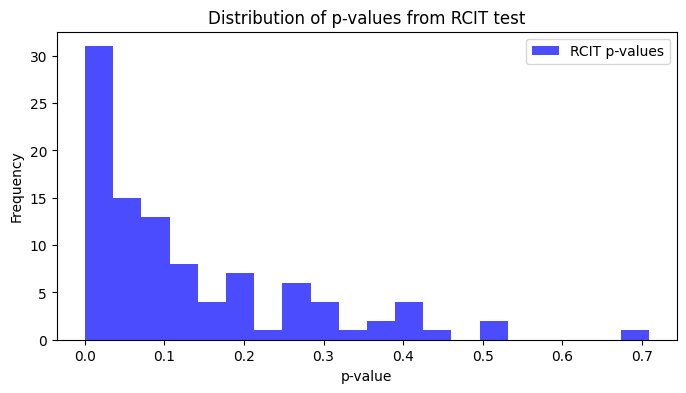

In [34]:
graph(p_values)

Unconditional

In [13]:
# normal
X = year_data_shifted  

x = year_data_shifted.columns.get_loc('Total Return_t+1')
y = year_data_shifted.columns.get_loc('total_emission_scope1')

In [14]:
p_values = RCIT_values(X, x, y, random_seed=True, n_runs=100)
p_mean = np.average(p_values)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 3.209789332372703e-05
Chi-square Statistic: 900.0, P-value: 6.186801032394592e-188


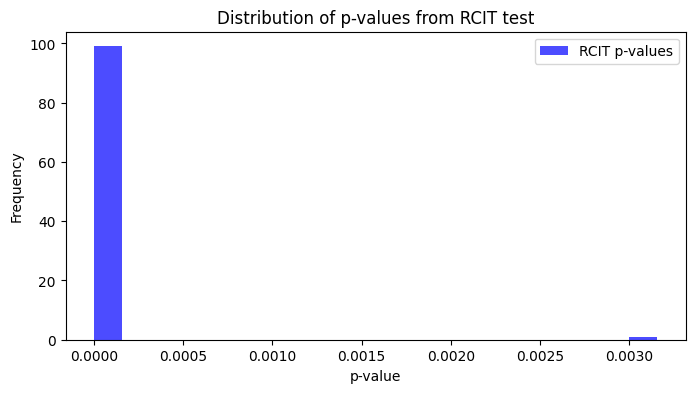

In [15]:
graph(p_values)

INVEST/A_t ⊥ RET_t+1 | LOGPPE_t, LOGSIZE_t, ROE_t, Total Emission Scope1_t, VOLAT_t

In [35]:
# normal
X = year_data_shifted  

x = year_data_shifted.columns.get_loc('Total Return_t+1')
y = year_data_shifted.columns.get_loc('INVEST_A')
z = [ year_data_shifted.columns.get_loc('LOGPPE'), year_data_shifted.columns.get_loc('LOGSIZE'),\
      year_data_shifted.columns.get_loc('VOLAT'), year_data_shifted.columns.get_loc('ROE'), \
      year_data_shifted.columns.get_loc('total_emission_scope1')]

In [36]:
p_values = RCIT_values(X, x, y, z, random_seed=True, n_runs=100)
p_mean = np.average(p_values)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.2893700440817474
Chi-square Statistic: 71.79999999999998, P-value: 6.7485052124756446e-12


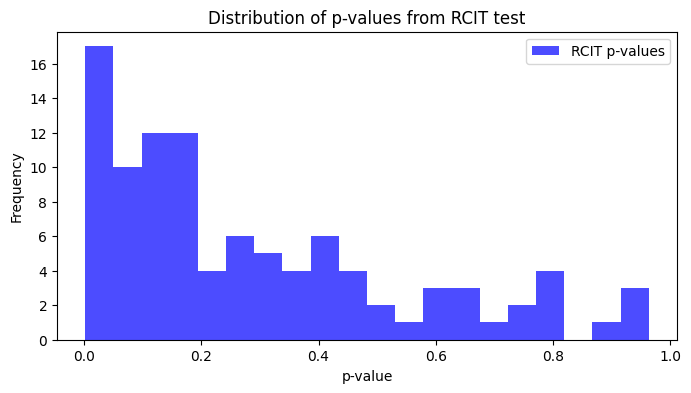

In [37]:
graph(p_values)

Unconditional

In [38]:
p_values = RCIT_values(X, x, y, random_seed=True, n_runs=100)
p_mean = np.average(p_values)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.05807850559548377
Chi-square Statistic: 590.0, P-value: 2.9310709644865212e-121


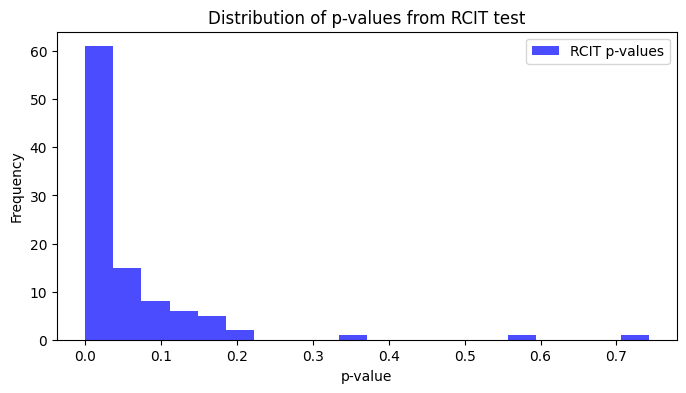

In [39]:
graph(p_values)

In [41]:
# changes
X = year_data_shifted  

x = year_data_shifted.columns.get_loc('Total Return_t+1')
y = year_data_shifted.columns.get_loc('INVEST_A')-year_data_shifted.columns.get_loc('INVEST_A_t-1')
z = [ year_data_shifted.columns.get_loc('LOGPPE')-year_data_shifted.columns.get_loc('LOGPPE_t-1'), year_data_shifted.columns.get_loc('LOGSIZE')-year_data_shifted.columns.get_loc('LOGSIZE_t-1'),\
      year_data_shifted.columns.get_loc('VOLAT')-year_data_shifted.columns.get_loc('VOLAT_t-1'), year_data_shifted.columns.get_loc('ROE')-year_data_shifted.columns.get_loc('ROE_t-1'), \
      year_data_shifted.columns.get_loc('total_emission_scope1')-year_data_shifted.columns.get_loc('total_emission_scope1_t-1')]

In [42]:
p_values = RCIT_values(X, x, y, z, random_seed=True, n_runs=100)
p_mean = np.average(p_values)
print(f"average p value: {p_mean}")

# uniformity test
chi2_statistic, p_value = chi2_test(p_values)
print(f"Chi-square Statistic: {chi2_statistic}, P-value: {p_value}")

average p value: 0.0007652783040182576
Chi-square Statistic: 900.0, P-value: 6.186801032394592e-188


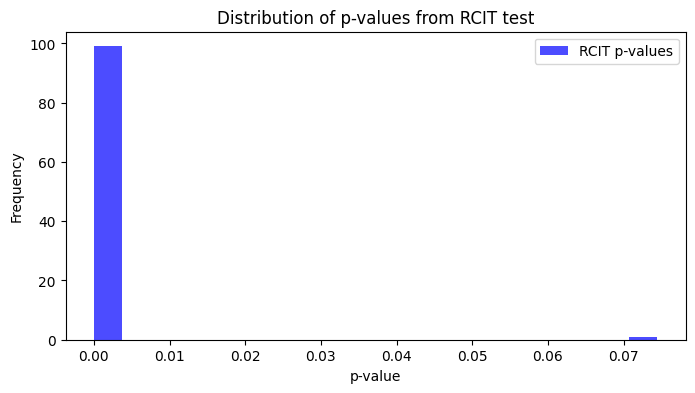

In [43]:
graph(p_values)